In [1]:
import os, glob

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sonnet as snt

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def process_image(image, normalize=True):
    """
    normalize will adjust all pixels of the image to lie between 0 and 1
    for every colour dimension.
    """
    
    img_tensor = tf.image.decode_image(image)
    img_tensor = tf.cast(img_tensor, tf.float32)
    
    if normalize:
        img_tensor /= 255.
        
    return img_tensor


def load_and_process_image(image_path):
    
    img_raw = tf.read_file(image_path)
    return process_image(img_raw)

In [3]:
COMPRESSION_SUBDIR = 'datasets/miracle_image_compression'

TRAIN_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_train.zip'
TRAIN_DATASET_ARCHIVE = 'train.zip'

VALIDATION_DATASET_URL = 'https://data.vision.ee.ethz.ch/cvl/clic/professional_valid.zip'
VALIDATION_DATASET_ARCHIVE = 'valid.zip'

valid_path = tf.keras.utils.get_file(fname=VALIDATION_DATASET_ARCHIVE, 
                                     origin=VALIDATION_DATASET_URL, 
                                     cache_subdir=COMPRESSION_SUBDIR,
                                     extract=True)

valid_path, _ = os.path.splitext(valid_path)

valid_path

'/Users/gergelyflamich/.keras/datasets/miracle_image_compression/valid'

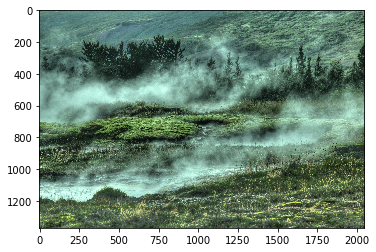

In [4]:
image_paths = glob.glob(valid_path + "/*.png")

test_img = load_and_process_image(image_paths[0])
plt.imshow(test_img)

[1370, 2048, 3]
[1, 685, 1024, 10]
[1, 1370, 2048, 3]


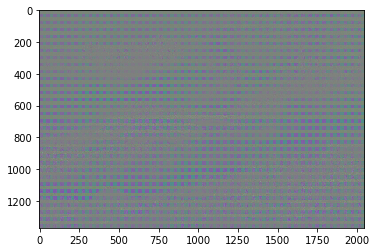

In [23]:
with tf.GradientTape() as tape:

    conv = snt.Conv2D(output_channels=10,
                      kernel_shape=(5, 5),
                      stride=2)

    print(test_img.shape.as_list())

    convolved = conv(test_img[tf.newaxis, ...])

    print(convolved.shape.as_list())

    conv_T = conv.transpose()

    deconvolved = conv_T(convolved)

    print(deconvolved.shape.as_list())
    
grads = tape.gradient(tf.reduce_sum(deconvolved), conv.get_all_variables())

plt.imshow(tf.nn.sigmoid(deconvolved[0, ...]))

In [9]:
paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = paths_dataset.map(load_and_process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#image_dataset = image_dataset.shuffle(buffer_size=10)

image_sizes = []

for image in image_dataset:
    
    image_sizes.append(image.shape)
    
    break

In [23]:
xs, ys, chans = zip(*map(lambda x: x.as_list(), image_sizes))
print("X min: {}, X max: {}, Y min: {}, Y max: {}".format(min(xs), max(xs), min(ys), max(ys)))

X min: 294, X max: 2048, Y min: 384, Y max: 2048


In [45]:
tf.contrib.layers.gdn

<function tensorflow.contrib.layers.python.layers.layers.gdn(inputs, inverse=False, beta_min=1e-06, gamma_init=0.1, reparam_offset=3.814697265625e-06, data_format='channels_last', activity_regularizer=None, trainable=True, name=None, reuse=None)>